# Time series using STAC API statistics endpoints

This notebook demonstrates how to generate a timeseries using STAC API statistics endpoints.

* Author: Leo Thomas
* Lasted Updated Date: June 29, 2022

In [1]:
import concurrent.futures
import datetime as dt
from ipyleaflet import basemaps, Map, GeoJSON
import json
import requests as re
import matplotlib.pyplot as plt
import pprint
import time

STAC_API_URL = "https://staging-stac.delta-backend.com"
RASTER_API_URL = "https://staging-raster.delta-backend.com"

# Declare your collection of interest

You can discover available collections the following ways:

* Use the `{STAC_ENDPOINT_URL}/collections` API endpoint (JSON response)
* Programmatically using `pystac` (see example in the `list-collections.ipynb` notebook
* In the STAC Browser: http://delta-staging-stac-browser.s3-website-us-east-1.amazonaws.com/


In [2]:
collection = 'no2-monthly'

## Discover data using the STAC endpoint

In [3]:
re.get(f"{STAC_API_URL}/collections/{collection}").json()

{'id': 'no2-monthly',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly'}],
 'title': 'NO₂',
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2016-01-01T00:00:00Z',
     '2022-01-01T00:00:00Z']]}},
 'license': 'MIT',
 'summaries': {'datetime': ['2016-01-01T00:00:00Z', '2022-05-01T00:00:00Z'],
  'cog_default': {'max': 50064805976866816, 'min': -6618294421291008}},
 'description': 'Darker colors indicate higher nitrogen dioxide (NO₂) levels and more activity. Lighter colors indicate lower levels of NO₂ an

## Describe the periodic nature of the data

In [5]:
pprint.pprint({
    k:v for k,v in re.get(f"{STAC_API_URL}/collections/no2-monthly").json().items()
    if k in ["dashboard:is_periodic", "dashboard:time_density", "summaries"]
})

{'dashboard:is_periodic': True,
 'dashboard:time_density': 'month',
 'summaries': {'cog_default': {'max': 50064805976866816,
                               'min': -6618294421291008},
               'datetime': ['2016-01-01T00:00:00Z', '2022-05-01T00:00:00Z']}}


## Load and inspect one of the STAC items

This step is just for demonstration, to inspect what an item looks like.

In [7]:
items = re.get(f"{STAC_API_URL}/collections/{collection}/items?limit=100").json()["features"]
items[0]

{'id': 'OMI_trno2_monthly_0.10x0.10_202205_Col3_V4.nc',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://staging-stac.delta-backend.com/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://staging-stac.delta-backend.com/collections/no2-monthly/items/OMI_trno2_monthly_0.10x0.10_202205_Col3_V4.nc'}],
 'assets': {'cog_default': {'href': 's3://veda-data-store-staging/no2-monthly/OMI_trno2_monthly_0.10x0.10_202205_Col3_V4.nc.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data', 'layer'],
   'raster:bands': [{'scale': 1.0,
     'nodata': -1.2676506002282294e+30,
     'offset': 0.0,

## Define a bounding box

We've defined a bounding box for France in this case.

In [8]:
bounding_box_france = { 
    "type": "Feature",
    "properties": {},
    "geometry": {
        "type": "Polygon",
        "coordinates": [[
            [
              -5.4534286,
              41.2632185
            ],
            [
              9.8678344,
              41.2632185
            ],
            [
              9.8678344,
              51.268318
            ],
            [
              -5.4534286,
              51.268318
            ],
            [
              -5.4534286,
              41.2632185
            ]
        ]]
    }
}



## Map the bounding box

This step is for visual inspection of the bounding box.

In [9]:
m = Map(
    basemap=basemaps.OpenStreetMap.Mapnik,
    center=(47,4),
    zoom=3
)
geo = GeoJSON(
    data=bounding_box_france,
    style={"color": "red", "fillOpacity": 0}
)
m.add_layer(geo)
m

Map(center=[47, 4], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Use `/cog/statistics` to get data for the bounding box

First, we create a `generate_stats` function and then we call it with the bounding box defined for France.

In [10]:
def generate_stats(items, bounding_box):
    stats = [
        {
            **re.post(
                f"{RASTER_API_URL}/cog/statistics", 
                params={
                    "url":item["assets"]["cog_default"]["href"]
                },
                json=bounding_box
            ).json()["properties"], 
             "start_datetime":item["properties"]["start_datetime"]
        }
        for item in items
    ]
    return stats

## Generate and estimate time to generate statistics

This may take a minute, depending on the network.

In [11]:
start = time.time()
stats = generate_stats(items, bounding_box_france)
end = time.time()
print(f"Elapsed time for small bounding box (france) {round(end-start,2)} seconds. Items queried: {len(items)}")

Elapsed time for small bounding box (france) 124.64 seconds. Items queried: 77


## Inspect one result

In [12]:
stats[1]

{'statistics': {'1': {'min': -1686681841303552.0,
   'max': 8037704876949504.0,
   'mean': 1719699112594799.0,
   'count': 15200.0,
   'sum': 2.6139426511440945e+19,
   'std': 1311942344229939.8,
   'median': 1358823029735424.0,
   'majority': 537238232367104.0,
   'minority': -1686681841303552.0,
   'unique': 15194.0,
   'histogram': [[7.0,
     568.0,
     6212.0,
     4554.0,
     2093.0,
     819.0,
     437.0,
     271.0,
     182.0,
     57.0],
    [-1686681841303552.0,
     -714243169478246.4,
     258195502347059.25,
     1230634174172365.0,
     2203072845997670.5,
     3175511517822976.0,
     4147950189648282.0,
     5120388861473587.0,
     6092827533298893.0,
     7065266205124199.0,
     8037704876949504.0]],
   'valid_percent': 99.35,
   'masked_pixels': 100.0,
   'valid_pixels': 15200.0,
   'percentile_98': 5865060032776768.0,
   'percentile_2': 116917669524930.58}},
 'start_datetime': '2022-04-01T00:00:00Z'}

In [13]:
dates = [dt.datetime.strptime(stat["start_datetime"], "%Y-%m-%dT%H:%M:%SZ") for stat in stats]
means = [stat["statistics"]["1"]["mean"] for stat in stats]
std_devs = [stat["statistics"]["1"]["std"] for stat in stats]
upper_bounds = [m+s for (m,s) in zip(means, std_devs)]
lower_bounds = [m-s for (m,s) in zip(means, std_devs)]

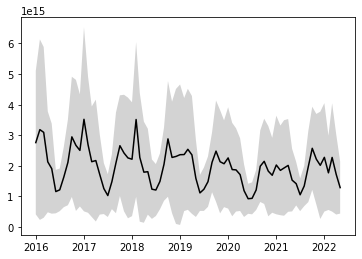

In [14]:
plt.plot(dates, means, 'black')
plt.fill_between(dates, upper_bounds, lower_bounds, facecolor="lightgrey", interpolate=True)